# Project Reality Demo Exploration


## Introduction
I have over 3800 demos from Project Reality with the intent of analyzing the trends of different maps. Specifically, I would like to investigate which maps are unbalanced. 


In [170]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

db_location = 'pr.db'
conn = sqlite3.connect(db_location)

df = pd.read_sql_query('SELECT * FROM demos;',conn)
conn.close()
df.head()
type(df['date'][0])


str

## Sample
Below I will show a little bit about the data I have gathered.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E97C63FD48>]],
      dtype=object)

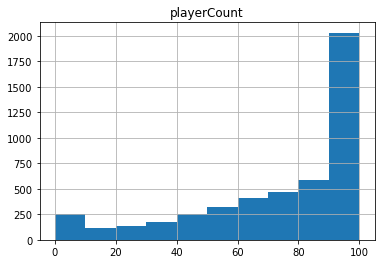

In [190]:
df = df.loc[(df['version'] != 'v1.5.5') & 
            (~df['mode'].isin(['Skirmish','Co-Operative']))
           ]
df.loc[df['server'].str.startswith('PRTA.co'), 'server'] = 'PRTA.co'
df.loc[df['server'].str.startswith('Gamma Group'), 'server'] = 'Gamma Group'
df.loc[df['server'].str.startswith('[DIVSUL'), 'server'] = 'DIVSUL'
df.loc[df['server'].str.startswith('PRSC'), 'server'] = 'DIVSUL'
df.loc[df['server'].str.startswith('CSA'), 'server'] = 'CSA'
df.loc[df['server'].str.startswith('=SF='), 'server'] = 'SF'
df.loc[df['server'].str.startswith("''(SSG)"), 'server'] = 'SSG'


df.hist(column='playerCount')

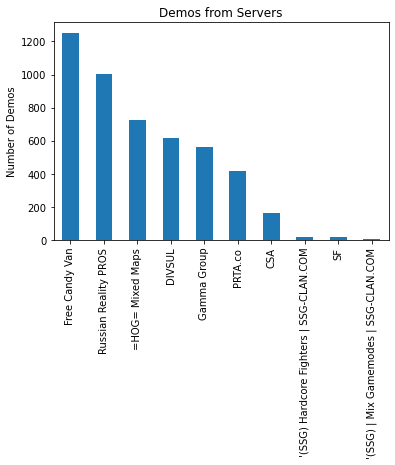

In [172]:
ax = df['server'].value_counts().plot(kind='bar')
ax.set_ylabel('Number of Demos')
ax.set_title('Demos from Servers')
plt.show()

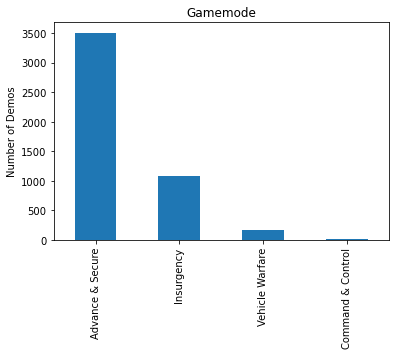

In [173]:
ax = df['mode'].value_counts().plot(kind='bar')
ax.set_ylabel('Number of Demos')
ax.set_title('Gamemode')
plt.show()

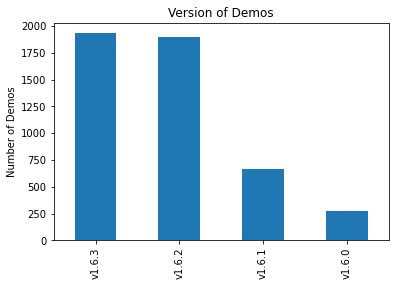

In [174]:
ax = df['version'].value_counts().plot(kind='bar')
ax.set_ylabel('Number of Demos')
ax.set_title('Version of Demos')
plt.show()

## Balancing

In [175]:
layerNames = {
    'Layer 64' : 'Standard',
    'Layer 32' : 'Alternative',
    'Layer 16' : 'Infantry',
    'Layer 128': 'Large'
}
df.replace({'layer':layerNames},inplace=True)
df['layer'].unique()

array(['Standard', 'Alternative', 'Large', 'Infantry'], dtype=object)

In [176]:
df['winningTeam'] = 0
df.loc[df['ticketsTeam1'] == 0, 'winningTeam'] = 2
df.loc[df['ticketsTeam2'] == 0, 'winningTeam'] = 1

df.loc[(df['winningTeam'] == 0) &
       (df['mode'] == 'Advance & Secure') &
       (df['ticketsTeam1'] < 10) &
       (df['ticketsTeam2'] > 10),
       'winningTeam'] = 2
df.loc[(df['winningTeam'] == 0) &
       (df['mode'] == 'Advance & Secure') &
       (df['ticketsTeam1'] > 10) &
       (df['ticketsTeam2'] < 10),
       'winningTeam'] = 1

df.loc[(df['winningTeam'] == 0) &
       (df['mode'] == 'Insurgency') &
       (df['ticketsTeam1'] > 1) &
       (df['ticketsTeam2'] < 10),
       'winningTeam'] = 1

In [177]:
counts = df.loc[(df['winningTeam'] > 0) &
       (df['playerCount'] > 50)
      ].groupby(['map','mode','layer','winningTeam'])['date'].agg(['count'])
counts

count
map        mode              layer       winningTeam       
albasrah_2 Insurgency        Alternative 1                1
                                         2               10
                             Infantry    1                2
                                         2                3
                             Standard    1               13
...                                                     ...
yamalia    Advance & Secure  Alternative 2                7
                             Infantry    2                2
                             Standard    1                4
                                         2                6
           Command & Control Infantry    1                1

[340 rows x 1 columns]

In [178]:
percentMaps = counts.groupby(level=[0,1,2]).apply(lambda g: g/g.sum()).reset_index()
percentMaps.rename(columns={'count': 'winPercent'}, inplace=True)
percentMaps['team1WinPercent'] = 0
percentMaps['team2WinPercent'] = 0
percentMaps.loc[percentMaps['winningTeam'] == 1, 'team1WinPercent'] = percentMaps['winPercent']
percentMaps.loc[percentMaps['winningTeam'] == 1, 'team2WinPercent'] = 1 - percentMaps['winPercent']
percentMaps.loc[percentMaps['winningTeam'] == 2, 'team2WinPercent'] = percentMaps['winPercent']
percentMaps.loc[percentMaps['winningTeam'] == 2, 'team1WinPercent'] = 1- percentMaps['winPercent']

percentMaps.drop(columns=['winningTeam','winPercent'], inplace=True)
percentMaps = percentMaps.drop_duplicates(['map','mode','layer'])
percentMaps.set_index(['map','mode','layer'], inplace=True)
percentMaps['count'] = counts.reset_index().groupby(['map','mode','layer'])['count'].agg(['sum'])['sum']
percentMaps.sort_values('count', ascending=False, inplace=True)

percentMaps.reset_index(inplace=True)

onek = ['asad_khal','assault_on_mestia','fallujah_west','hill_488','korengal',
        'merville','operation_ghost_train','reichswald','tad_sae']
fourk = ['bijar_canyons','black_gold','burning_sands','hades_peak',
        'kashan_desert','khamisiyah','masirah','operation_soul_rebel',
        'iron_thunder','pavlovsk_bay','saaremaa','silent_eagle',
        'vadso_city','wanda_shan','xiangshan']
np.sort(df['map'].unique())
percentMaps['size'] = 2
percentMaps.loc[percentMaps['map'].isin(onek),'size'] = 1
percentMaps.loc[percentMaps['map'].isin(fourk),'size'] = 4
percentMaps.loc[percentMaps['map'] == 'the_falklands','size'] = 8



In [179]:
minimumNumberOfPlays = 20
balanceThreshold = 0.55
percentMaps.loc[(percentMaps['count'] > minimumNumberOfPlays) &
                (percentMaps['team1WinPercent'] < balanceThreshold) &
                (percentMaps['team2WinPercent'] < balanceThreshold)
               ]

map              mode     layer  team1WinPercent  \
4               beirut  Advance & Secure  Standard         0.546512   
20    operation_falcon  Advance & Secure     Large         0.488372   
21       kashan_desert  Advance & Secure  Standard         0.452381   
25          black_gold  Advance & Secure  Standard         0.461538   
26  battle_of_ia_drang  Advance & Secure  Standard         0.461538   
27           asad_khal  Advance & Secure  Standard         0.512821   
32        pavlovsk_bay  Advance & Secure  Standard         0.542857   
43           musa_qala        Insurgency  Standard         0.466667   
45         goose_green  Advance & Secure  Standard         0.535714   
48              ramiel  Advance & Secure  Standard         0.538462   
49        shijiavalley  Advance & Secure  Standard         0.461538   
50   assault_on_grozny        Insurgency  Standard         0.480000   
55            nuijamaa  Advance & Secure  Standard         0.476190   

    team2WinPercent  count  size  
4          0.453488     86     2  
20         0.511628     43     2  
21         0.547619     42     4  
25         0.538462     39     4  
26         0.538462     39     2  
27         0.487179     39     1  
32         0.457143     35     4  
43         0.533333     30     2  
45         0.464286     28     2  
48         0.461538     26     2  
49         0.538462     26     2  
50         0.520000     25     2  
55         0.523810     21     2

In [180]:
unbalanceThreshold = 0.7
percentMaps.loc[(percentMaps['count'] > minimumNumberOfPlays) &
                ((percentMaps['team1WinPercent'] > unbalanceThreshold) |
                (percentMaps['team2WinPercent'] > unbalanceThreshold))
               ]
# percentMaps.reset_index(inplace=True)
# percentMaps.loc[percentMaps['map'] == 'iron_thunder']

map              mode        layer  team1WinPercent  \
0       fallujah_west        Insurgency     Standard         0.238095   
6              gaza_2        Insurgency     Standard         0.297297   
8         kafar_halab  Advance & Secure     Standard         0.296875   
12        kafar_halab  Advance & Secure  Alternative         0.254902   
16      fallujah_west        Insurgency     Infantry         0.187500   
22       iron_thunder  Advance & Secure     Standard         0.714286   
24     ras_el_masri_2        Insurgency     Standard         0.756098   
35      fallujah_west        Insurgency  Alternative         0.187500   
37          ulyanovsk  Advance & Secure     Standard         0.741935   
38            karbala        Insurgency     Standard         0.709677   
51  assault_on_grozny  Advance & Secure  Alternative         0.280000   
54   operation_archer        Insurgency     Standard         0.190476   
56         hades_peak  Advance & Secure  Alternative         0.285714   

    team2WinPercent  count  size  
0          0.761905    126     1  
6          0.702703     74     2  
8          0.703125     64     2  
12         0.745098     51     2  
16         0.812500     48     1  
22         0.285714     42     4  
24         0.243902     41     2  
35         0.812500     32     1  
37         0.258065     31     2  
38         0.290323     31     2  
51         0.720000     25     2  
54         0.809524     21     2  
56         0.714286     21     4

In [181]:
percentMaps.loc[(percentMaps['mode'].isin(['Advance & Secure'])) &
               (~percentMaps['layer'].isin(['Infantry']))].iloc[-20:-1]


map              mode        layer  team1WinPercent  \
130          vadso_city  Advance & Secure  Alternative         0.600000   
131               dovre  Advance & Secure  Alternative         0.600000   
132          fools_road  Advance & Secure  Alternative         0.000000   
133            nuijamaa  Advance & Secure  Alternative         0.500000   
134        shijiavalley  Advance & Secure  Alternative         0.500000   
135           ulyanovsk  Advance & Secure  Alternative         0.250000   
138        silent_eagle  Advance & Secure  Alternative         0.250000   
139            korengal  Advance & Secure     Standard         0.000000   
140             tad_sae  Advance & Secure  Alternative         0.000000   
142  battle_of_ia_drang  Advance & Secure  Alternative         0.666667   
147              gaza_2  Advance & Secure  Alternative         0.333333   
152       the_falklands  Advance & Secure  Alternative         0.500000   
164              beirut  Advance & Secure  Alternative         0.000000   
167           xiangshan  Advance & Secure  Alternative         0.000000   
168              bamyan  Advance & Secure        Large         1.000000   
172             tad_sae  Advance & Secure     Standard         1.000000   
174        dovre_winter  Advance & Secure  Alternative         1.000000   
176               sahel  Advance & Secure  Alternative         0.000000   
177          dragon_fly  Advance & Secure  Alternative         0.000000   

     team2WinPercent  count  size  
130         0.400000      5     4  
131         0.400000      5     2  
132         1.000000      4     2  
133         0.500000      4     2  
134         0.500000      4     2  
135         0.750000      4     2  
138         0.750000      4     4  
139         1.000000      4     1  
140         1.000000      4     1  
142         0.333333      3     2  
147         0.666667      3     2  
152         0.500000      2     8  
164         1.000000      1     2  
167         1.000000      1     4  
168         0.000000      1     2  
172         0.000000      1     1  
174         0.000000      1     2  
176         1.000000      1     2  
177         1.000000      1     2

In [182]:
ticketThreshold = 50
closeGames = df.loc[(df['mode'] == 'Advance & Secure') 
       & (df['playerCount'] > 50) 
       & (df['ticketsTeam1'] < ticketThreshold) 
       & (df['ticketsTeam2'] < ticketThreshold)].groupby(['map', 'layer'])['date'].agg(['count'])
closeGames.sort_values(by='count', ascending=False, inplace=True)
closeGames.loc[closeGames['count'] > 5]

count
map                layer             
masirah            Standard        17
muttrah_city_2     Standard        14
beirut             Standard        14
saaremaa           Standard        12
khamisiyah         Alternative     10
operation_marlin   Standard        10
ulyanovsk          Standard         9
kafar_halab        Standard         9
khamisiyah         Standard         9
battle_of_ia_drang Standard         8
burning_sands      Standard         8
kafar_halab        Alternative      7
carentan           Standard         7
gaza_2             Standard         7
route              Standard         6
dragon_fly         Standard         6
operation_falcon   Large            6
brecourt_assault   Alternative      6
kashan_desert      Standard         6
assault_on_grozny  Standard         6
operation_falcon   Standard         6
asad_khal          Standard         6

In [183]:
np.sort(percentMaps['map'].unique())

array(['albasrah_2', 'asad_khal', 'assault_on_grozny',
       'assault_on_mestia', 'bamyan', 'battle_of_ia_drang', 'beirut',
       'bijar_canyons', 'black_gold', 'brecourt_assault', 'burning_sands',
       'carentan', 'charlies_point', 'dovre', 'dovre_winter',
       'dragon_fly', 'fallujah_west', 'fools_road', 'gaza_2',
       'goose_green', 'hades_peak', 'hill_488', 'iron_ridge',
       'iron_thunder', 'jabal', 'kafar_halab', 'karbala', 'kashan_desert',
       'khamisiyah', 'kokan', 'korengal', 'kozelsk', 'lashkar_valley',
       'masirah', 'merville', 'musa_qala', 'muttrah_city_2', 'nuijamaa',
       'omaha_beach', 'op_barracuda', 'operation_archer',
       'operation_falcon', 'operation_ghost_train', 'operation_marlin',
       'operation_soul_rebel', 'outpost', 'pavlovsk_bay', 'qwai1',
       'ramiel', 'ras_el_masri_2', 'reichswald', 'route', 'saaremaa',
       'sahel', 'sbeneh_outskirts', 'shahadah', 'shijiavalley',
       'silent_eagle', 'tad_sae', 'the_falklands', 'ulyanovsk',


In [184]:
vietnamMaps = ['battle_of_ia_drang','charlies_point','hill_488']
percentMaps.loc[(percentMaps['map'].isin(vietnamMaps)) |
               ((percentMaps['map'].isin(['op_barracuda','tad_sae']) &
               (percentMaps['layer'] == 'Alternative')))]

map              mode        layer  team1WinPercent  \
26   battle_of_ia_drang  Advance & Secure     Standard         0.461538   
71       charlies_point  Advance & Secure     Standard         0.411765   
74         op_barracuda  Advance & Secure  Alternative         0.437500   
79             hill_488  Advance & Secure     Standard         0.571429   
140             tad_sae  Advance & Secure  Alternative         0.000000   
142  battle_of_ia_drang  Advance & Secure  Alternative         0.666667   
155  battle_of_ia_drang  Advance & Secure     Infantry         0.500000   

     team2WinPercent  count  size  
26          0.538462     39     2  
71          0.588235     17     2  
74          0.562500     16     2  
79          0.428571     14     1  
140         1.000000      4     1  
142         0.333333      3     2  
155         0.500000      2     2

In [185]:
mapTeams = pd.read_csv('map_modes.csv')
percentMaps = pd.merge(percentMaps,mapTeams, how='left',left_on=['map','mode','layer'],right_on=['map','mode','layer'])
percentMaps

map               mode     layer  team1WinPercent  \
0            fallujah_west         Insurgency  Standard         0.238095   
1           muttrah_city_2   Advance & Secure  Standard         0.427350   
2                  masirah   Advance & Secure  Standard         0.402174   
3            burning_sands   Advance & Secure  Standard         0.333333   
4                   beirut   Advance & Secure  Standard         0.546512   
..                     ...                ...       ...              ...   
182          kashan_desert  Command & Control  Infantry         1.000000   
183   operation_soul_rebel   Advance & Secure  Infantry         1.000000   
184  operation_ghost_train   Advance & Secure  Infantry         1.000000   
185       operation_falcon   Advance & Secure  Infantry         1.000000   
186                yamalia  Command & Control  Infantry         1.000000   

     team2WinPercent  count  size       team1        team2  
0           0.761905    126     1  Insurgents         USMC  
1           0.572650    117     2         MEC         USMC  
2           0.597826     92     4         MEC       France  
3           0.666667     87     4         MEC          BAF  
4           0.453488     86     2      Russia          IDF  
..               ...    ...   ...         ...          ...  
182         0.000000      1     4         MEC       Canada  
183         0.000000      1     4      Russia          BAF  
184         0.000000      1     1         NaN          NaN  
185         0.000000      1     2      Russia  Netherlands  
186         0.000000      1     2      Russia       Canada  

[187 rows x 9 columns]

In [186]:
team = 'USMC'
percentMaps.loc[((percentMaps['team1'] == team) | (percentMaps['team2'] == team)) & (percentMaps['count'] > 5)]
#percentMaps['mode'].unique()

map              mode        layer  team1WinPercent  \
0        fallujah_west        Insurgency     Standard         0.238095   
1       muttrah_city_2  Advance & Secure     Standard         0.427350   
7             saaremaa  Advance & Secure     Standard         0.393939   
14          khamisiyah  Advance & Secure     Standard         0.340000   
16       fallujah_west        Insurgency     Infantry         0.187500   
19               jabal  Advance & Secure     Standard         0.395349   
32        pavlovsk_bay  Advance & Secure     Standard         0.542857   
35       fallujah_west        Insurgency  Alternative         0.187500   
41      muttrah_city_2  Advance & Secure  Alternative         0.433333   
53           musa_qala        Insurgency  Alternative         0.666667   
58            saaremaa  Advance & Secure        Large         0.700000   
61              bamyan  Advance & Secure     Standard         0.578947   
90       fallujah_west  Advance & Secure     Standard         0.272727   
91        op_barracuda  Advance & Secure     Standard         0.272727   
92               jabal  Advance & Secure  Alternative         0.636364   
97       kashan_desert  Advance & Secure        Large         0.600000   
101  assault_on_mestia  Advance & Secure     Standard         0.555556   
106             bamyan  Advance & Secure  Alternative         0.555556   

     team2WinPercent  count  size       team1 team2  
0           0.761905    126     1  Insurgents  USMC  
1           0.572650    117     2         MEC  USMC  
7           0.606061     66     4      Russia  USMC  
14          0.660000     50     4         MEC  USMC  
16          0.812500     48     1  Insurgents  USMC  
19          0.604651     43     2         MEC  USMC  
32          0.457143     35     4      Russia  USMC  
35          0.812500     32     1  Insurgents  USMC  
41          0.566667     30     2         MEC  USMC  
53          0.333333     24     2     Taliban  USMC  
58          0.300000     20     4      Russia  USMC  
61          0.421053     19     2         MEC  USMC  
90          0.727273     11     1         MEC  USMC  
91          0.727273     11     2         PLA  USMC  
92          0.363636     11     2         FSA  USMC  
97          0.400000     10     4         MEC  USMC  
101         0.444444      9     1     Militia  USMC  
106         0.444444      9     2     Taliban  USMC

In [187]:
team1 = percentMaps['team1'].unique()
team2 = percentMaps['team2'].unique()
allTeams = np.unique(np.concatenate((team1,team2),axis=None))
allTeams

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
for team in allTeams:
    print(percentMaps.loc[(percentMaps['team1'] == team) | (percentMaps['team2'] == team)])